# **Simpsons Classification**

Kaggle: Daria Remizova <br>
Kaggle + Stepik ID: Daria_Remizova_564975032<br>

Task: Классификация изображений/ Image Classification<br>

Model: Resnet50<br>

Metric: F1-Score<br>

Public Score on Kaggle: 0.98831<br>

Определим доступность графического процессора для ускорения обучения нейронных сетей с использованием библиотеки PyTorch. <br>

Let's determine the availability of the GPU to accelerate the training of neural networks using the PyTorch library. <br>

In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


Проверим, какая версия у библиотеки для обработки изображений Pillow (PIL). <br>
Let's check the version of Pillow (PIL).<br>

* PIL является устаревшей и не обновляется с 2011 года. Pillow поддерживает структуру, схожую с PIL для обеспечения обратной совместимости.<br>

* PIL is not updated since 2011. Pillow supports a structure similar to PIL for backward compatibility.

In [2]:
import PIL
print(PIL.__version__)

9.5.0


выводит информацию о состоянии и использовании графических процессоров NVIDIA 

In [3]:
# информация о состоянии и использовании графических процессоров NVIDIA 
# GPU status and usage information    
!nvidia-smi
import torch
# проверка наличия и возможности использования GPU PyTorch.
# Если возвращает True, то PyTorch настроен на использование GPU
# в противном случае - на CPU
# checking availability and usability GPU PyTorch
# if True - GPU is OK, if False - CPU
torch.cuda.is_available()

Wed Nov 22 16:46:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [4]:
# импорт модуля Python для сериализации и десериализации объектов
# importing a Python module for serializing and deserializing objects
import pickle
import numpy as np
#  импорт функции io из библиотеки scikit-image для работы с вводом/выводом изображений
# import io function from scikit-image library for image input/output
from skimage import io

# импорт инструментов для создания индикаторов выполнения (progress bars) в консоли
# instruments for making progress bars in console
from tqdm import tqdm, tqdm_notebook
# модуль для работы с изображениями
# module for work with images
from PIL import Image
# импорт класса Path для работы с путями к файлам и директориями
# impor class Path for work with paths to files and directories
from pathlib import Path

# импорт модуля transforms, он предоставляет функции для преобразования изображений 
# import transforms module, it provides functions for image transforming
# импорт модуля models, который содержит предобученные модели глубокого обучения
# importing the models module, which contains pre-trained deep learning models
from torchvision import transforms, models
# импорт класса ThreadPool для выполнения параллельных задач с испольтзованием потоков
# import class ThreasPool to perform parallel tasks
from multiprocessing.pool import ThreadPool
# импорт класса LabelEncoder для кодирования меток
# import LabelEncoder class for encoding labels
from sklearn.preprocessing import LabelEncoder
# импорт классов для создания пользовательских наборов данных и загрузки данных
# import classes for to create custom datasets and load data
from torch.utils.data import Dataset, DataLoader
# импорт модуля nn для определения нейронных сетей
# importing the nn module to define neural networks
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
# ignore warnings to see images
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# введем некоторые константы
# define some cosntants 

# разные режимы датасета
# different dataset modes
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
# all images will be scalled 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
# work on video card
DEVICE = torch.device("cuda")

ToTensor конвертирует PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:  𝑖𝑛𝑝𝑢𝑡=𝑖𝑛𝑝𝑢𝑡−𝜇standard deviation ,
константы - средние и дисперсии по каналам на основе ImageNet

Стоит также отметить, что мы переопределяем метод getitem для удобства работы с данной структурой данных. Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод _prepare_sample)

ToTensor converts a PIL Image with parameters in the range [0, 255] (like all pixels) into a FloatTensor of size (C x H x W) [0,1] , then scales: 𝑖𝑛𝑝𝑢𝑡=𝑖𝑛𝑝𝑢𝑡−𝜇standard deviation ,
constants - means and variances across channels based on ImageNet

We also override the getitem method to make it easier to work with this data structure. LabelEncoder is also used to convert string class labels to ids and back. The description of the dataset states that the pictures are of different sizes, since they were taken directly from the video, so we should bring them to the same size (this is done by the _prepare_sample method)

In [6]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    A dataset with pictures that simultaneously loads them from folders
    performs scaling and transformation into butt tensors
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        # list of files to download
        self.files = sorted(files)
        # режим работы
        # operating mode
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        # to convert images to PyTorch tensors and normalize input
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
    # наш датасет содержит картинки разного размера, поэтому приведем к одному
    # our dataset has images of different sizes, make the size equal
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [7]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [8]:
# определим директории с тренировочными и тестовыми файлами
# define directories with train and test files
TRAIN_DIR = Path('/kaggle/input/journey-springfield/train')
TEST_DIR = Path('/kaggle/input/journey-springfield/testset')

In [9]:
# создадим списки путей к файлам изображений 
# для загрузки данных при обучении и тестировании модели
# create lists of paths to image files
# for loading data when training and testing the model
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

Разделим данные на обучающую и валидационную выборки. Stratified sampling (стратифицированная выборка) гарантирует, что распределение классов в обучающем и валидационном наборах останетсе схожим с исходным набором данных. Это важно для предотвращения смещения в распределении классов и повышения обобщающей способности модели.<br>

Let's divide the data into training and validation samples. Stratified sampling ensures that the distribution of classes in the training and validation sets remains similar to the original data set. This is important to prevent bias in the class distribution and improve the generalization ability of the model.

In [10]:
from sklearn.model_selection import train_test_split

# создаем список меток для каждого файла в train_val_files
# в данном случае, метки берутся из имен родительских директорий каждого файла
# create a list of tags for each file in train_val_files
# in this case, the labels are taken from the names of the parent directories of each file
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [11]:
val_dataset = SimpsonsDataset(val_files, mode='val')

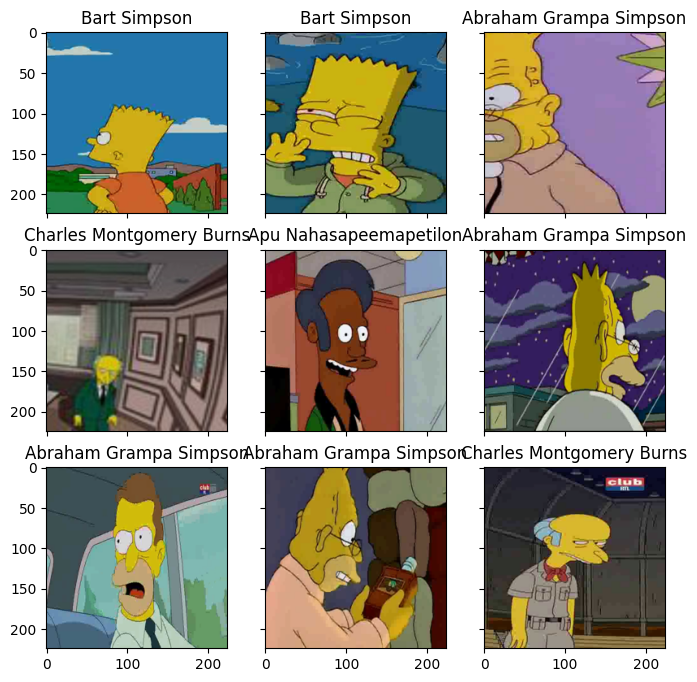

In [12]:
# посмотрим на некоторые изображения из данных
# see some pictures from data
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

## Resnet50

In [13]:
# определения количества уникальных классов в обучающем и валидационном наборах данных
# determining the number of unique classes in the training and validation data sets
n_classes = len(np.unique(train_val_labels))
# вывод сообщения о том, сколько классов будет использоваться для классификации 
# print a message about how many classes will be used for classification
print("number to classify :{}".format(n_classes))

number to classify :42


In [14]:
# создание экземпляра предобученной модели resnet50 
# instantiate the resnet50 pretrained model
model = models.resnet50(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 242MB/s] 


In [15]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
# num_features - размерность вектора признаков, поступающего на вход FC-слою
# num_features - dimension of the feature vector input to the FC layer
num_features = 2048
# адаптация модели для текущей задачи классификации с 42 классами
# adaptation of the model for the current classification problem with 42 classes
model.fc = nn.Linear(num_features, 42)

In [17]:
# перенос моделм на устройство, указанное в переменной DEVICE
# transfer model to the device specified in the DEVICE variable
resnet_model = model.to(DEVICE)

In [18]:
# функция одной эпохи обучения модели
# function of one model training epoch
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train(True)
    # накопление общей потери на текущей эпохе
    # accumulation of total loss for the current epoch
    running_loss = 0.0
    # накопление общего количества правильных предсказаний
    # накопление общего количества правильных предсказаний
    running_corrects = 0
    # накопление общего количества обработанных данных
    # accumulation of the total amount of processed data
    processed_data = 0
    
    # итерация по данным обучающего набора
    # iteration over training set data
    for inputs, labels in train_loader:
        # перенос входных данных на устройство
        # transfer input data to device
        inputs = inputs.to(DEVICE)
        # перенос меток на устройство
        # transfer tags to device
        labels = labels.to(DEVICE)
        # обнуление градиентов
        # zeroing gradients
        optimizer.zero_grad()

        # получение предсказаний от модели
        # getting predictions from the model
        outputs = model(inputs)
        # вычисление потерь
        # loss calculation
        loss = criterion(outputs, labels)
        # обратное распространение ошибки
        # backpropagation
        loss.backward()
        # обновление весов модели на основе градиентов
        # update model weights based on gradients
        optimizer.step()
        # получение индексов предсказанных классов
        # get indexes of predicted classes
        preds = torch.argmax(outputs, 1)
        # обновление общей потери
        # update total loss
        running_loss += loss.item() * inputs.size(0)
        # обновление общего числа правильных предсказаний
        # update the total number of correct predictions
        running_corrects += torch.sum(preds == labels.data)
        # обновление общего числа обработанных данных
        # update the total number of processed data
        processed_data += inputs.size(0)
    
    # вычисление среднего лосса
    # average loss calculation
    train_loss = running_loss / processed_data
    # вычисление точности
    # calculate accuracy
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [19]:
# функция оценки модели на валидационном наборе данных
# function for evaluating the model on the validation data set
def eval_epoch(model, val_loader, criterion):
    # установка модели в режим оценки
    # setting the model to evaluation mode
    model.eval()
    # накопление общего лосса на валидационном наборе
    # accumulation of total loss on the validation set
    running_loss = 0.0
    # накопление общего количества правильных предсказаний
    # накопление общего количества правильных предсказаний
    running_corrects = 0
    # накопление общего количества обработанных данных
    # accumulation of the total amount of processed data
    processed_size = 0

    # итерация по данным валидационного набора
    # iterate through the validation set data
    for inputs, labels in val_loader:
        # перенос входных данных на устройство
        # transfer input data to device
        inputs = inputs.to(DEVICE)
        # перенос меток на устройство
        # transfer tags to device
        labels = labels.to(DEVICE)

        # оценка без градиентов
        # score without gradients
        with torch.set_grad_enabled(False):
            # получение предсказаний от модели
            # getting predictions from the model
            outputs = model(inputs)
            # вычисление потерь
            # loss calculation
            loss = criterion(outputs, labels)
            # получение индексов предсказанных классов
            # get indexes of predicted classes
            preds = torch.argmax(outputs, 1)
        
        # обновление общей потери
        # update total loss
        running_loss += loss.item() * inputs.size(0)
        # обновление общего числа правильных предсказаний
        # update the total number of correct predictions
        running_corrects += torch.sum(preds == labels.data)
        # обновление общего числа обработанных данных
        # update the total number of processed data
        processed_size += inputs.size(0)
        
    # вычисление среднего лосса
    # average loss calculation    
    val_loss = running_loss / processed_size
    # вычисление точности
    # calculate accuracy 
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [20]:
# функция обучения модели на обучающем наборе и
# оценки ее производительности на валидационном наборе
# function of training the model on the training set and
# evaluation of its performance on the validation set
def train(train_files, val_files, model, epochs, batch_size):
    # создание DataLoader для обучающего и валидационного наборов данных соответственно
    # creating a DataLoader for the training and validation datasets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # инициализация истории обучения
    # initialize learning history
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    # использование tqdm для создания прогресс-бара по эпохам
    # use tqdm to create a progress bar by era
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        # инициализация оптимизатора Adam для обновления весов модели
        # initialize the Adam optimizer to update the model weights
        opt = torch.optim.Adam(model.parameters(), lr=1e-4)
        # инициализация функции потерь (кросс-энтропия)
        # initialize the loss function (cross-entropy)
        criterion = nn.CrossEntropyLoss()

        # итерация по эпохам
        # iterate over epochs
        for epoch in range(epochs):
            #  обучение модели на обучающем наборе и получение потерь и точности на обучении
            # train the model on the training set and obtain losses and accuracy on training
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            # оценка модели на валидационном наборе и получение потерь и точности на валидации
            # evaluate the model on the validation set and obtain losses and accuracy on validation
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            # добавление результатов в историю
            # adding results to history
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            # вывод статистики обучения и валидации для текущей эпохи
            # output training and validation statistics for the current epoch
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [21]:
# функция для получения предсказаний модели на тестовом наборе данных
# function to obtain model predictions on a test data set
def predict(model, test_loader):
    # включение контекста для выполнения операций без вычисления градиентов
    # это увеличивает производительность и экономит память при предсказаниях
    # enable context to perform operations without calculating gradients
    # this increases performance and saves memory when making predictions
    with torch.no_grad():
        logits = []
        
        # итерация по тестовому набору данных
        # iterate over the test data set
        for inputs in test_loader:
            # перенос входных данных на устройство
            # transfer input data to device
            inputs = inputs.to(DEVICE)
            # установка модели в режим оценки
            # setting the model to evaluation mode
            model.eval()
            # Получение предсказаний от модели и перенос их на CPU. 
            # cpu() используется, чтобы преобразовать тензоры на CPU и обеспечить совместимость с numpy
            # Receiving predictions from the model and transferring them to the CPU.
            # cpu() is used to convert tensors on the CPU and provide numpy compatibility
            outputs = model(inputs).cpu()
            # добавление предсказаний в список logits
            # adding predictions to the logits list
            logits.append(outputs)

    # соединение предсказаний и преобразование их в вероятности с использованием softmax
    # результат преобразуется в массив numpy
    # connecting predictions and converting them into probabilities using softmax
    # the result is converted to a numpy array
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    # возвращаются предсказанные вероятности для тестового набора данных
    # returned predicted probabilities for the test data set
    return probs

## Обучение нейросети
## Neural Network Training

In [22]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [23]:
history = train(train_dataset, val_dataset, model=resnet_model, epochs=10, batch_size=64)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.6854037242077271


epoch:  10%|█         | 1/10 [05:19<47:56, 319.61s/it]


Epoch 001 train_loss: 0.6854     val_loss 0.2186 train_acc 0.8539 val_acc 0.9442
loss 0.10470485496281044


epoch:  20%|██        | 2/10 [09:02<35:01, 262.74s/it]


Epoch 002 train_loss: 0.1047     val_loss 0.1505 train_acc 0.9769 val_acc 0.9633
loss 0.04177934556480001


epoch:  30%|███       | 3/10 [12:42<28:21, 243.06s/it]


Epoch 003 train_loss: 0.0418     val_loss 0.1591 train_acc 0.9908 val_acc 0.9612
loss 0.022386773253188722


epoch:  40%|████      | 4/10 [16:22<23:25, 234.27s/it]


Epoch 004 train_loss: 0.0224     val_loss 0.1814 train_acc 0.9952 val_acc 0.9520
loss 0.021713630675783552


epoch:  50%|█████     | 5/10 [20:00<19:00, 228.14s/it]


Epoch 005 train_loss: 0.0217     val_loss 0.2233 train_acc 0.9946 val_acc 0.9513
loss 0.03242921824192984


epoch:  60%|██████    | 6/10 [23:36<14:56, 224.07s/it]


Epoch 006 train_loss: 0.0324     val_loss 0.2140 train_acc 0.9920 val_acc 0.9476
loss 0.02606077873712133


epoch:  70%|███████   | 7/10 [27:11<11:03, 221.23s/it]


Epoch 007 train_loss: 0.0261     val_loss 0.1576 train_acc 0.9931 val_acc 0.9637
loss 0.010388895659249211


epoch:  80%|████████  | 8/10 [30:50<07:20, 220.30s/it]


Epoch 008 train_loss: 0.0104     val_loss 0.1336 train_acc 0.9976 val_acc 0.9692
loss 0.014525594411930279


epoch:  90%|█████████ | 9/10 [34:27<03:39, 219.46s/it]


Epoch 009 train_loss: 0.0145     val_loss 0.1986 train_acc 0.9966 val_acc 0.9555
loss 0.015333828094335101


epoch: 100%|██████████| 10/10 [38:05<00:00, 228.56s/it]


Epoch 010 train_loss: 0.0153     val_loss 0.1433 train_acc 0.9963 val_acc 0.9700


Построим кривые обучения <br>
Let's build learning curves

In [24]:
loss, acc, val_loss, val_acc = zip(*history)

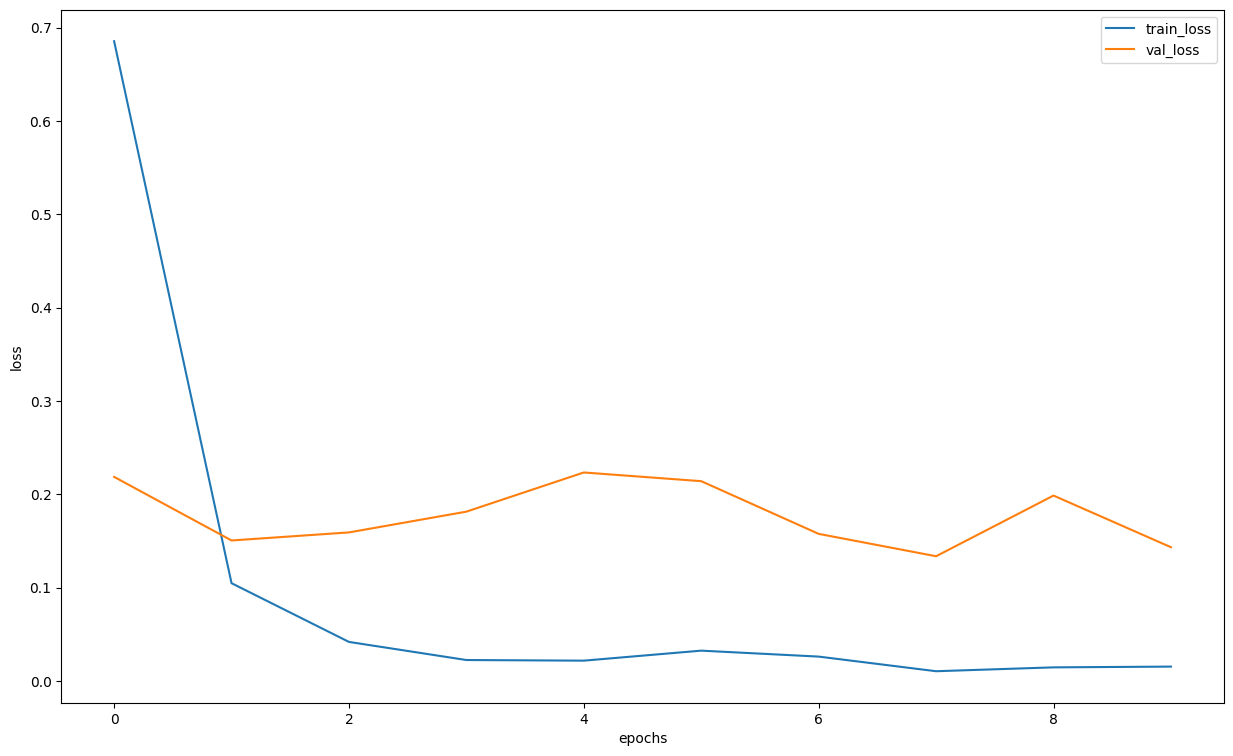

In [25]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Предсказание
## Prediction

In [26]:
# функция предсказания модели для одного случайного элемента из валидационного набора данных
# model prediction function for one random element from the validation dataset
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    # переносим входные данные на устройство
    # transfer the input data to the device
    with torch.no_grad():
        inputs = inputs.to(device)
        # устанавливаем модель в режим оценки
        # set the model to evaluation mode
        model.eval()
        # получаем логиты (непосредственный вывод модели перед применением softmax)
        # get logits (direct output of the model before applying softmax)
        logit = model(inputs).cpu()
        # применяем softmax для получения вероятностей и преобразуем в numpy-массив
        # use softmax to obtain probabilities and convert to a numpy array
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [27]:
# выбор случайного числа для выбора элемента из валидационного набора данных
# select a random number to select an element from the validation set
random_characters = int(np.random.uniform(0,1000))
# получение изображения и соответствующей метки из валидационного набора данных 
# по случайно выбранному индексу random_characters
# get the image and corresponding label from the validation data set
# by randomly selected index random_characters
ex_img, true_label = val_dataset[random_characters]
# используется функция predict_one_sample
# чтобы получить предсказания модели (resnet_model) для данного изображения
# use predict_one_sample function
# to get model predictions (resnet_model) for a given image
probs_im = predict_one_sample(resnet_model, ex_img.unsqueeze(0))

In [28]:
# создается список из 20 случайных чисел (индексов) в интервале от 0 до 1000
# creates a list of 20 random numbers (indexes) in the range from 0 to 1000
idxs = list(map(int, np.random.uniform(0,1000, 20)))
# формируется список imgs, содержащий изображения, извлеченные из валидационного набора данных
# по случайным индексам idxs. Каждое изображение при этом расширяется с использованием 
# unsqueeze(0).
# an imgs list is generated containing images extracted from the validation dataset
# by random idxs indexes. Each image is then expanded using
# unsqueeze(0).
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
# используется функция predict для получения предсказаний модели (resnet_model) 
# для списка изображений imgs
# функция predict вероятностные предсказания для каждого изображения возвращает в виде списка
# use the predict function to get model predictions (resnet_model)
# for a list of imgs images
# function predict returns probabilistic predictions for each image as a list
probs_ims = predict(resnet_model, imgs)

In [29]:
# open("label_encoder.pkl", 'rb'): 
# Открывает файл с именем "label_encoder.pkl" в режиме чтения бинарных данных ('rb')
# pickle.load(...): Загружает объект из файла.
# open("label_encoder.pkl", 'rb'):
# Opens a file named "label_encoder.pkl" in binary reading mode ('rb')
# pickle.load(...): Loads an object from a file.
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [30]:
# вычисляем индексы классов с наибольшей вероятностью для каждого предсказания в probs_ims
# calculate class indices with the highest probability for each prediction in probs_ims
y_pred = np.argmax(probs_ims,-1)
# получаем факт. метки классов из валидационного набора для случайно выбранных изображений 
# get the fact class labels from the validation set for randomly selected images
actual_labels = [val_dataset[id][1] for id in idxs]
# преобразуем предсказанные индексы классов (y_pred) обратно в соответствующие текстовые метки 
# классов с использованием объекта label_encoder.classes_
# таким образом, preds_class становится списком текстовых меток, предсказанных моделью

# преобразуем предсказанные индексы классов (y_pred) обратно в соответствующие текстовые метки 
# классов с использованием объекта label_encoder.classes_
# таким образом, preds_class становится списком текстовых меток, предсказанных моделью
# convert predicted class indices (y_pred) back into corresponding text labels
# classes using the label_encoder.classes_ object
# so preds_class becomes a list of text labels predicted by the model
preds_class = [label_encoder.classes_[i] for i in y_pred]

## Вычисление метрики F1-score
## Calculate F1-score metric

In [31]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-score:", f1)

F1-score: 1.0


## Визуализация уверенности модели
## Visualization of model confidence

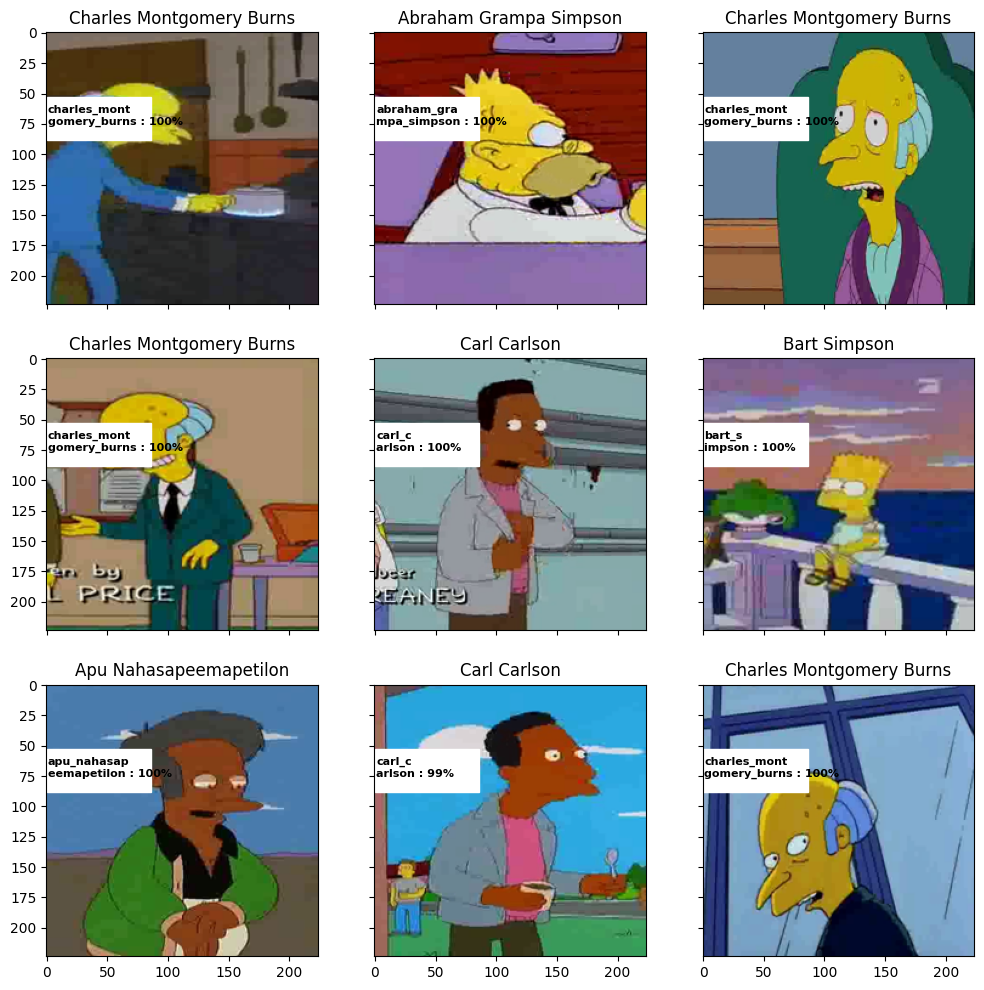

In [32]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

# создаем сетку из 3 строк и 3 столбцов графиков с общими осью y и x
# create a grid of 3 rows and 3 columns of graphs with common y and x axes
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
# итерируется по всем осям в сетке
# iterates over all axes in the grid
for fig_x in ax.flatten():
    # выбираем случайный индекс изображения из валидационного набора
    # select a random image index from the validation set
    random_characters = int(np.random.uniform(0,1000))
    # получаем изображение и соответствующую метку из валидационного набора
    # get the image and the corresponding label from the validation set
    im_val, label = val_dataset[random_characters]
    # преобразует текстовую метку в формате "class_name" в более читаемый вид
    # где каждое слово начинается с заглавной буквы
    # converts a text label in the "class_name" format to a more readable form
    # where each word begins with a capital letter
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))


    # отображаем изображение с заголовком на текущей оси графика
    # display an image with a title on the current graph axis
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)
    # добавляем прямоугольник и текст с предсказанными метками и вероятностью на график
    # добавляем прямоугольник и текст с предсказанными метками и вероятностью на график
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    # вычисляем предсказанные вероятности для текущего изображения
    # calculate predicted probabilities for the current image
    prob_pred = predict_one_sample(resnet_model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

## Анализ неправильно классифицированных изображений
## Analysis of misclassified images

In [33]:
# запишем в список неверно классифицированные изображения
# add incorrectly classified images to the list
incorrect_predictions = []

for idx in range(len(val_dataset)):
    img, label = val_dataset[idx]
    predicted_probs = predict_one_sample(resnet_model, img.unsqueeze(0))
    predicted_label = np.argmax(predicted_probs)
    
    if predicted_label != label:
        actual_class = val_dataset.label_encoder.classes_[label]
        predicted_class = val_dataset.label_encoder.classes_[predicted_label]
        incorrect_predictions.append({
            'image_index': idx,
            'actual_class': actual_class,
            'predicted_class': predicted_class,
            'predicted_probs': predicted_probs
        })

In [34]:
import pandas as pd
df_incorrect = pd.DataFrame(incorrect_predictions).drop(columns=['predicted_class'])
class_counts = df_incorrect.groupby(['actual_class']).size().reset_index(name='count')
class_counts_sorted = class_counts.sort_values(by='count', ascending=False)
class_counts_sorted

,actual_class,count
0,abraham_grampa_simpson,13
12,homer_simpson,13
24,moe_szyslak,13
4,charles_montgomery_burns,9
25,ned_flanders,9
3,bart_simpson,7
17,lisa_simpson,7
5,chief_wiggum,6
18,maggie_simpson,6
29,principal_skinner,5


Посмотрим на ошибки предсказаний для класса homer_simpson.<br>
Let's look at the prediction errors for the homer_simpson class.

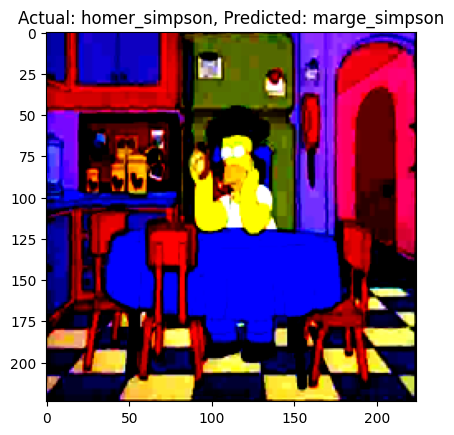

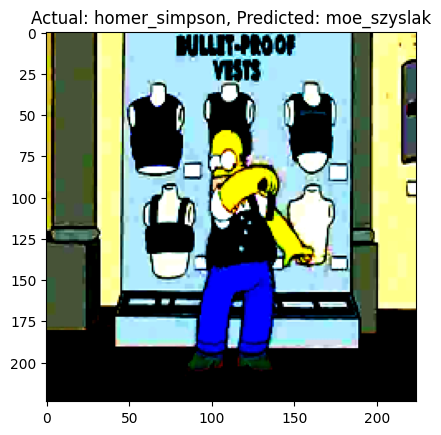

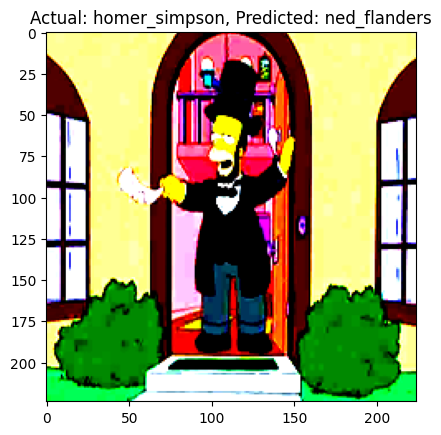

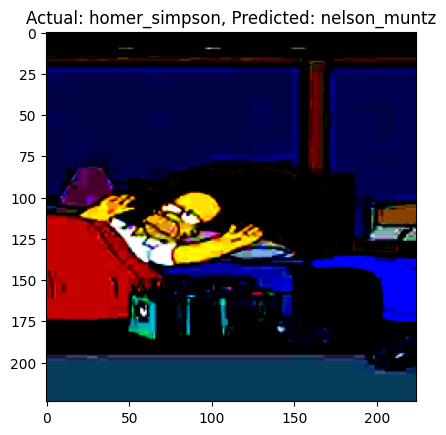

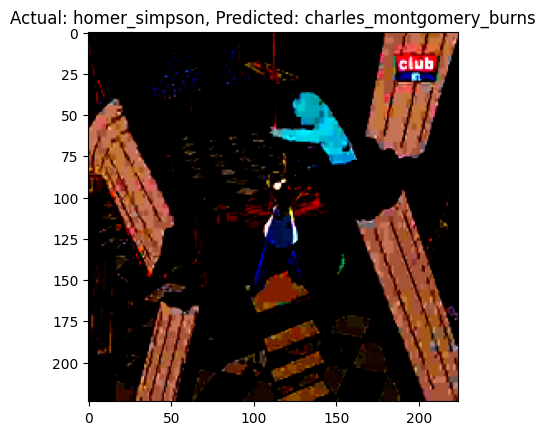

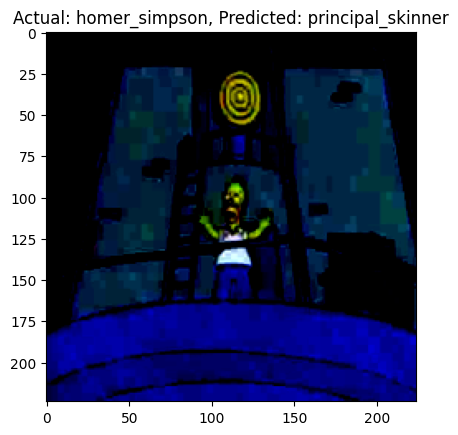

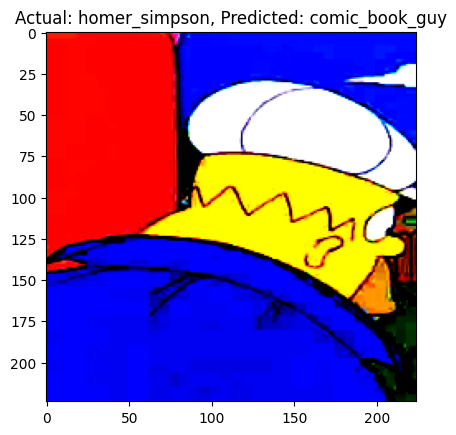

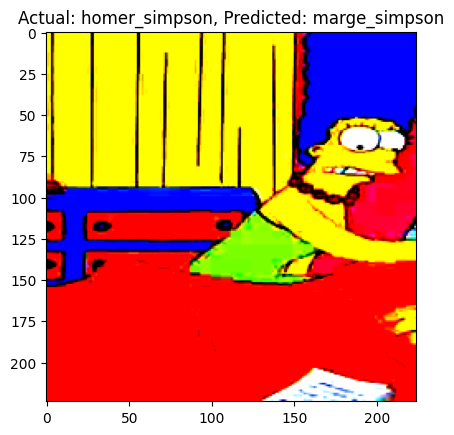

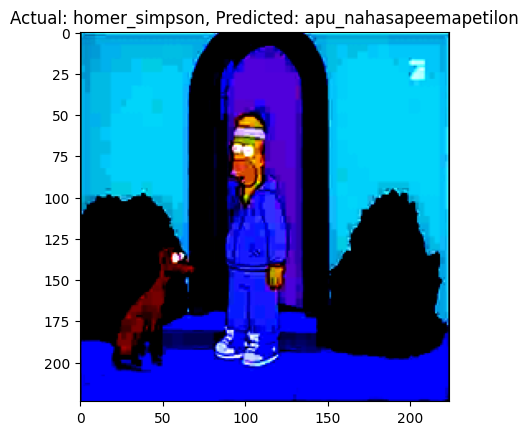

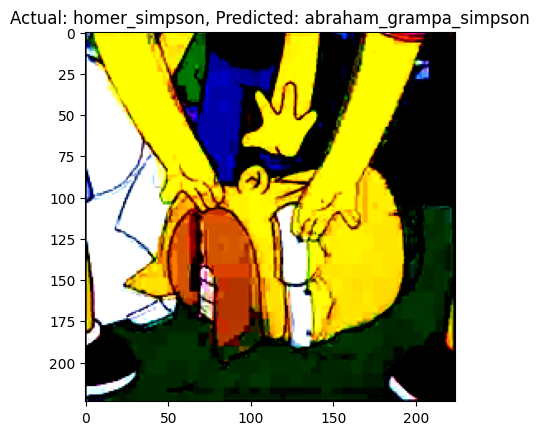

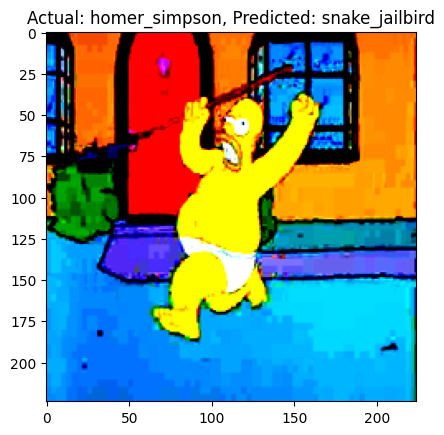

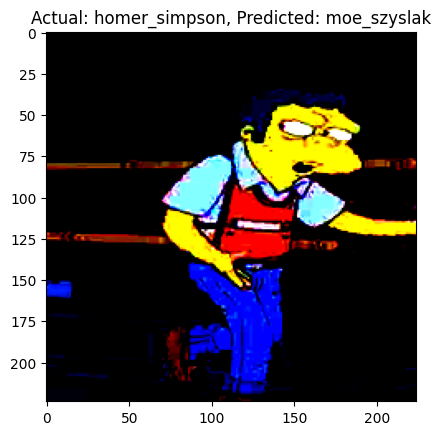

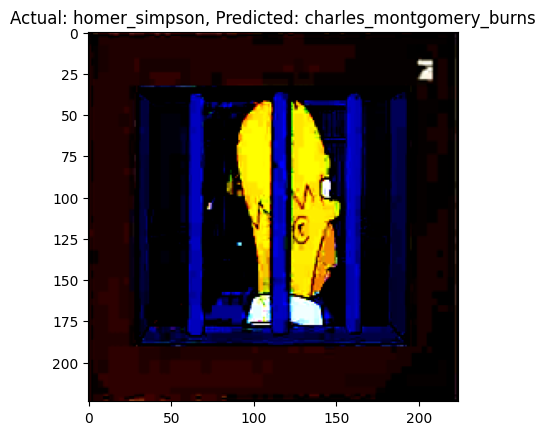

In [35]:
# визуализируем изображение с актуальной и предсказанной меткой
# render the image with the actual and predicted label
for prediction in incorrect_predictions:
    img_index = prediction['image_index']
    img, label = val_dataset[img_index]
    
    actual_class = prediction['actual_class']
    predicted_class = prediction['predicted_class']
    
    # Проверяем, является ли актуальный класс "homer_simpson"
    if actual_class == 'homer_simpson':
        plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        plt.title(f"Actual: {actual_class}, Predicted: {predicted_class}")
        plt.show()

Как мы можем заметить, во многих случаях проблема не в модели, а в разметке исхордных данных. На неверно классифицированном изображении либо несколько персонажей, либо вообще другой. <br>


As we can see, in many cases the problem is not in the model, but in the markup of the source data. An incorrectly classified image has either multiple characters or a different one.

## Submit

In [36]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(resnet_model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [37]:
! ls

label_encoder.pkl


In [38]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [39]:
my_submit.to_csv('resnet50.csv', index=False)